<a href="https://colab.research.google.com/github/TheBuilderHero/Deep_Learning_Road_Mapping/blob/main/True_Final_Project_Task_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import needed Libraries

In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import matplotlib.pyplot as plt
import zipfile
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Download and decompress Data

In [2]:
! pip install -q kaggle

In [3]:
from google.colab import files

In [4]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"thebuilderherokota","key":"705cf075e6b380effd0f2494d5e39123"}'}

In [5]:
! mkdir ~/.kaggle

In [6]:
! cp kaggle.json ~/.kaggle/

In [7]:
! chmod 600 ~/.kaggle/kaggle.json

In [8]:
#! kaggle datasets list
!kaggle datasets download -d balraj98/deepglobe-road-extraction-dataset

Dataset URL: https://www.kaggle.com/datasets/balraj98/deepglobe-road-extraction-dataset
License(s): other
100% 3.79G/3.79G [00:39<00:00, 121MB/s]
100% 3.79G/3.79G [00:39<00:00, 104MB/s]


In [9]:
!unzip -q /content/deepglobe-road-extraction-dataset.zip

In [10]:
!ls -l

total 3980156
-rw-r--r-- 1 root root         46 Nov 10  2020 class_dict.csv
-rw-r--r-- 1 root root 4074676823 Nov 10  2020 deepglobe-road-extraction-dataset.zip
-rw-r--r-- 1 root root         74 May  1 23:59 kaggle.json
-rw-r--r-- 1 root root     434416 Nov 10  2020 metadata.csv
drwxr-xr-x 1 root root       4096 Apr 30 13:20 sample_data
drwxr-xr-x 2 root root      36864 May  1 23:59 test
drwxr-xr-x 2 root root     450560 May  2 00:00 train
drwxr-xr-x 2 root root      45056 May  2 00:00 valid


## Get min size information associated with picture data

This is not really needed since we know the data is of size 1024 x 1024 but still kept it since it also provides the number of items.

In [11]:
from PIL import Image
filenames = []
sizes = []
index=1

# This is my path
paths = ["test", "valid", "train"]

# dirs=directories
for path in paths:
  for (root, dirs, file) in os.walk(path):
    for f in file:
        if '.jpg' in f:
            filenames.append(f)
            filename = root + "/" + f
            sizes.append([Image.open(filename, 'r').size,index])
            index += 1


#print(sizes)
print(max(sizes))
#print(min(sizes))

# Define the target size
value = min(sizes)
#print(value[0])
target_size = value[0]  # Specify the new width and height

[(1024, 1024), 8570]


## Load image data and Rescale pictures to smallest picture size

In [12]:
#!pip uninstall keras-preprocessing
!pip install git+https://github.com/keras-team/keras-preprocessing.git

  Cloning https://github.com/keras-team/keras-preprocessing.git to /tmp/pip-req-build-wg8f5c99
  Running command git clone --filter=blob:none --quiet https://github.com/keras-team/keras-preprocessing.git /tmp/pip-req-build-wg8f5c99
  Resolved https://github.com/keras-team/keras-preprocessing.git to commit 3e380065d4afc7347aaee8d89325a16b22158438
  Preparing metadata (setup.py) ... done
  Created wheel for Keras-Preprocessing: filename=Keras_Preprocessing-1.1.2-py3-none-any.whl size=43609 sha256=2e7a4722a02a4712ee6a3ab5cfc20a58fe557c9ea4a43806d6b6654099a398fe
  Stored in directory: /tmp/pip-ephem-wheel-cache-e9cfab47/wheels/72/0b/c7/3f6b26f2d789c712867e02502e1f1b740091f8615f32a9f870
Successfully built Keras-Preprocessing


In [13]:
# this loads gets all the file names for both the pictures and their masks and puts them into a dataframe.
metadata_df = pd.read_csv(os.path.join("./", 'metadata.csv'))
class_df = pd.read_csv(os.path.join("./", 'class_dict.csv'))
metadata_train_df = metadata_df[metadata_df["split"] == "train"]
metadata_test_df = metadata_df[metadata_df["split"] == "test"]

#remove the plit column now that it is not needed:
metadata_train_df.drop("split",inplace=True,axis=1)
metadata_test_df.drop("split",inplace=True,axis=1)

#test does not need the mask path since it is gonna generate them:
metadata_test_df.drop("mask_path",inplace=True,axis=1)

#fix indexing:
metadata_train_df = metadata_train_df.reset_index()
metadata_test_df = metadata_test_df.reset_index()

# get full path to the images
metadata_train_df['sat_image_path'] = metadata_train_df['sat_image_path'].apply(lambda img_pth: os.path.join("./", img_pth))
metadata_train_df['mask_path'] = metadata_train_df['mask_path'].apply(lambda img_pth: os.path.join("./", img_pth))
metadata_test_df['sat_image_path'] = metadata_test_df['sat_image_path'].apply(lambda img_pth: os.path.join("./", img_pth))

<ipython-input-13-d3138a5cf9b2>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_train_df.drop("split",inplace=True,axis=1)
<ipython-input-13-d3138a5cf9b2>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_test_df.drop("split",inplace=True,axis=1)
<ipython-input-13-d3138a5cf9b2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_test_df.drop("mask_path",inplace=True,axis=1)


#### Shuffle and split data

In [14]:
metadata_train_df = metadata_train_df.sample(frac=1).reset_index(drop=True)

In [15]:
valid_df = metadata_train_df.sample(frac=0.2,random_state=42)
train_df = metadata_train_df.drop(valid_df.index)

#### Get class data

In [16]:
class_names = class_df["name"].tolist()

In [17]:
RGB_values = class_df[["r","g","b"]].values.tolist()

In [18]:
Class_Type = ['background', 'road']

In [19]:
# Makes the class values 0 and 1
Class_Indices = [class_names.index(cls.lower()) for cls in Class_Type]

In [20]:
Class_RGB_Values = np.array(RGB_values)[Class_Indices]
# Creates a matrix of class RGB values

## Image Loading and Processing

In [21]:
import cv2
import pandas as pd
import tensorflow as tf

data_size = [3000,256,256] # size of images reduced by factor of 4 and we are taking the first 3000 images.

reduced_data = train_df[0:data_size[0]].reset_index(drop=True)

sat_images = []
mask_images = []

# Read into the program each image:
for img, mask in zip(reduced_data.sat_image_path, reduced_data.mask_path):
    img = cv2.cvtColor(cv2.imread(img),cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(data_size[1],data_size[2]))
    img = img/255.

    mask = cv2.cvtColor(cv2.imread(mask),cv2.COLOR_BGR2RGB)
    mask = cv2.resize(mask,(data_size[1],data_size[2]))
    mask = mask/255.

    sat_images.append(img)
    mask_images.append(mask[:,:,0]) # this is because its a binary mask and img is present in channel 0

In [22]:
reduced_data = valid_df[0:data_size[0]].reset_index(drop=True)

sat_images_valid = []
mask_images_valid = []

# Read into the program each image:
for img, mask in zip(reduced_data.sat_image_path, reduced_data.mask_path):
    img = cv2.cvtColor(cv2.imread(img),cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(data_size[1],data_size[2]))
    img = img/255.

    mask = cv2.cvtColor(cv2.imread(mask),cv2.COLOR_BGR2RGB)
    mask = cv2.resize(mask,(data_size[1],data_size[2]))
    mask = mask/255.

    sat_images_valid.append(img)
    mask_images_valid.append(mask[:,:,0]) # this is because its a binary mask and img is present in channel 0

In [23]:
#print(sat_images[0])
#print(mask_images[0])

### Getting some random samples of the data

Image shape: 3000, Mask shape: 3000


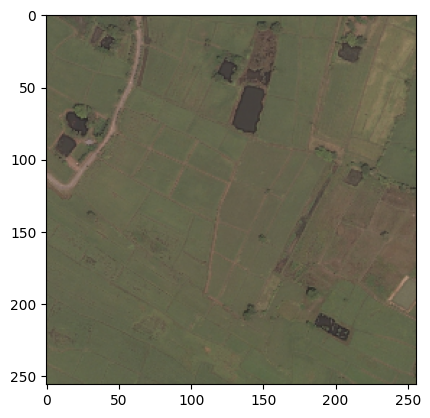

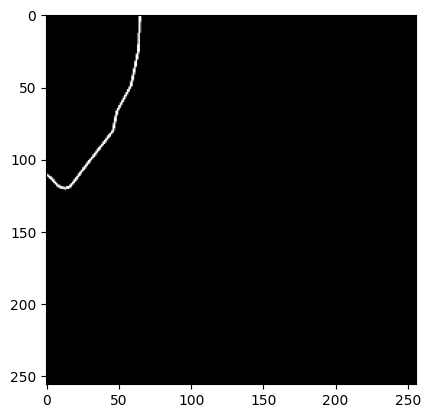

Image shape: 3000, Mask shape: 3000


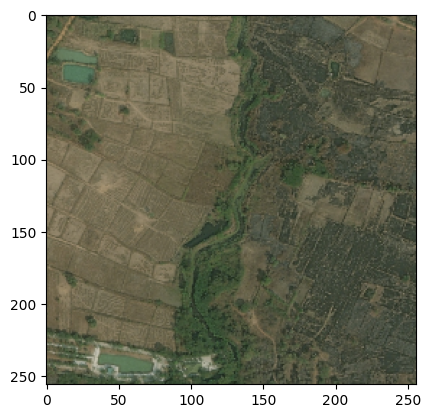

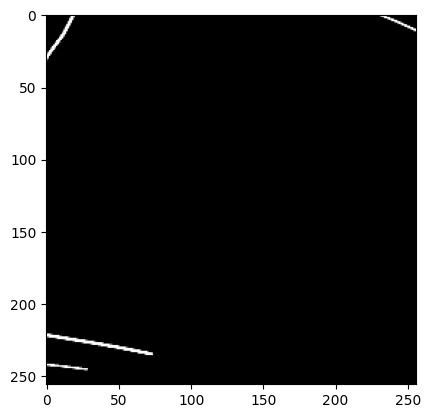

Image shape: 3000, Mask shape: 3000


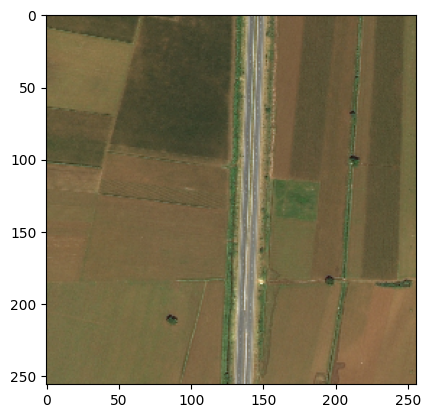

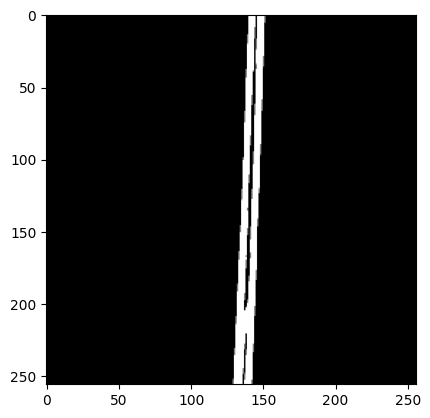

Image shape: 3000, Mask shape: 3000


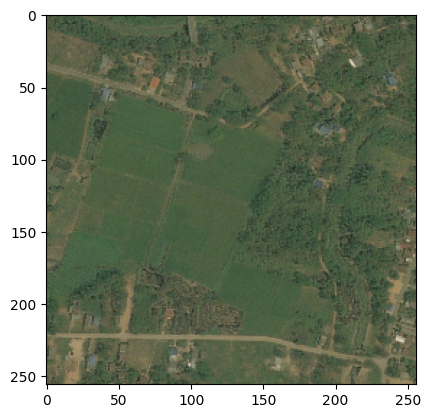

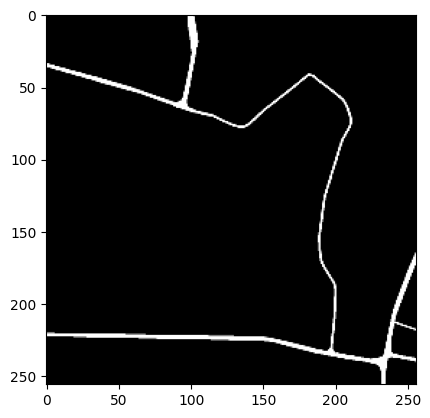

Image shape: 3000, Mask shape: 3000


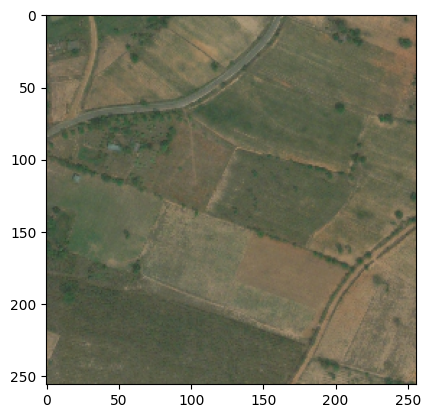

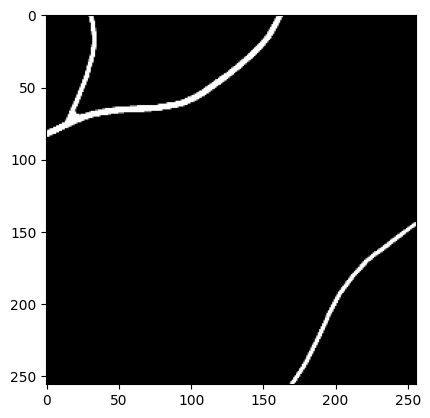

In [24]:
import random
for i in range(5):
  # Setup the dataset # Note that the class_rgb_values is being set to the RGB values of the input classes values.
  random_idx = random.randint(0, len(sat_images)-1)
  #image, mask = reduced_data[random_idx].sat_image_path, reduced_data[random_idx].mask_path # get some random sample
  print(f"Image shape: {len(sat_images)}, Mask shape: {len(mask_images)}")
  import matplotlib.pyplot as plt
  plt.imshow(sat_images[random_idx])
  plt.show()

  # Convert multi-channel mask to single-channel mask just for the sake of showing it.
  mask_single_channel = mask_images[random_idx]
  plt.imshow(mask_single_channel, cmap='gray')
  plt.show()

  #plt.imshow(mask)
  #plt.show()

## Build the model

In [25]:
model = Sequential()
model.add( Conv2D( 128, ( 5, 5 ), activation = 'relu', input_shape = (data_size[1],data_size[2],3), padding='same' ))
print(model.output_shape)
print(model.input_shape)
#model.add( MaxPool2D(3, 3) )
#model.add(Dropout(0.10))
#model.add( Conv2D( 64, ( 3, 3 ), activation = 'relu' , padding='same') )
#model.add(BatchNormalization())


#model.add( MaxPool2D(2, 2) )
#model.add(Dropout(0.10))
#model.add( Conv2D( 128, ( 5, 5 ), activation = 'relu', padding='same') )
#model.add( MaxPool2D(2, 2) )


#model.add(Dropout(0.10))
#model.add( Conv2D( 64, ( 5, 5 ), activation = 'relu', padding='same') )
#model.add(BatchNormalization())


#model.add( MaxPool2D(2, 2) )
#model.add(Dropout(0.10))
#model.add( Conv2D( 64, ( 7, 7 ), activation = 'relu', padding='same') )
#model.add( MaxPool2D(2, 2) )
#model.add(Dropout(0.10))

#duplicated for complexity
#model.add( Conv2D( 128, ( 7, 7 ), activation = 'relu', padding='same' ))
#model.add(BatchNormalization())
#model.add( MaxPool2D(3, 3) )
#model.add(Dropout(0.10))


#model.add( Conv2D( 64, ( 5, 5 ), activation = 'relu' , padding='same') )
#model.add( MaxPool2D(2, 2) )
#model.add(Dropout(0.10))
model.add( Conv2D( 64, ( 5, 5 ), activation = 'relu', padding='same') )
#model.add(BatchNormalization())


#model.add( MaxPool2D(2, 2) )
#model.add(Dropout(0.10))
model.add( Conv2D( 32, ( 3, 3 ), activation = 'relu', padding='same') )
#model.add( MaxPool2D(2, 2) )
#model.add(Dropout(0.10))
model.add( Conv2D( 16, ( 3, 3 ), activation = 'relu', padding='same') )
#model.add( Conv2D( 8, ( 3, 3 ), activation = 'relu', padding='same' ) )
#model.add( Flatten() )
#model.add( Dense( 512, activation = 'relu' ) )
#model.add( Dense( 256, activation = 'sigmoid' ) )


model.add( Conv2D( 1, ( 3, 3 ), activation = 'sigmoid', padding='same' ) )

(None, 256, 256, 128)
(None, 256, 256, 3)


In [26]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

# Define the filepath for saving the weights
filepath = "model_weights.h5"

# Load the saved weights into the model
#model.load_weights("model_weights.h5")

# Define a ModelCheckpoint callback to save the weights
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')

## Compile the model and overfit it to the Data

In [27]:
sat_images = np.array(sat_images)
mask_images = np.array(mask_images)

sat_images_reshaped = sat_images.reshape((-1, 256, 256, 3))
mask_images_reshaped = mask_images.reshape((-1, 256, 256, 1))

In [28]:
model.compile( optimizer = 'adam', loss= 'categorical_crossentropy', metrics = [ 'accuracy' ])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 128)     9728      
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 64)      204864    
                                                                 
 conv2d_2 (Conv2D)           (None, 256, 256, 32)      18464     
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 16)      4624      
                                                                 
 conv2d_4 (Conv2D)           (None, 256, 256, 1)       145       
                                                                 
Total params: 237825 (929.00 KB)
Trainable params: 237825 (929.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


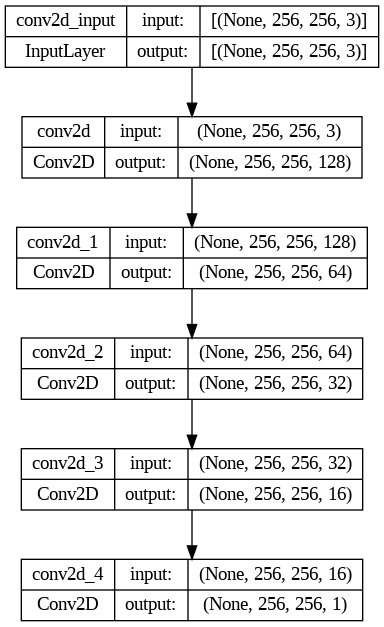

In [29]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [30]:
# Load the saved weights into the model
#model.load_weights("model_weights.h5")

In [31]:
#train_generator_one_hot.element_spec
history = model.fit(sat_images,mask_images, batch_size=2, epochs = 20, callbacks=[checkpoint,earlystop], validation_split=0.2)

Epoch 1/20
1200/1200 [==============================] - 31s 20ms/step - loss: 59.7962 - accuracy: 0.0756 - val_loss: 60.0918 - val_accuracy: 0.0387
Epoch 2/20
   9/1200 [..............................] - ETA: 19s - loss: 63.8392 - accuracy: 0.0409

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1200/1200 [==============================] - 22s 19ms/step - loss: 59.8521 - accuracy: 0.0608 - val_loss: 60.0948 - val_accuracy: 0.0397
Epoch 3/20
1200/1200 [==============================] - 23s 19ms/step - loss: 59.8978 - accuracy: 0.0398 - val_loss: 60.0933 - val_accuracy: 0.0391
Epoch 4/20
1200/1200 [==============================] - 23s 19ms/step - loss: 59.8341 - accuracy: 0.0701 - val_loss: 58.5247 - val_accuracy: 0.5844
Epoch 5/20
1200/1200 [==============================] - 23s 19ms/step - loss: 59.8904 - accuracy: 0.0444 - val_loss: 60.0874 - val_accuracy: 0.0409
Epoch 6/20
1200/1200 [==============================] - 23s 19ms/step - loss: 58.9679 - accuracy: 0.3592 - val_loss: 57.2975 - val_accuracy: 0.7799
Epoch 7/20
1200/1200 [==============================] - 23s 19ms/step - loss: 56.6723 - accuracy: 0.7257 - val_loss: 56.2437 - val_accuracy: 0.7313
Epoch 8/20
1200/1200 [==============================] - 23s 19ms/step - loss: 55.7475 - accuracy: 0.8931 - val_loss: 55.108

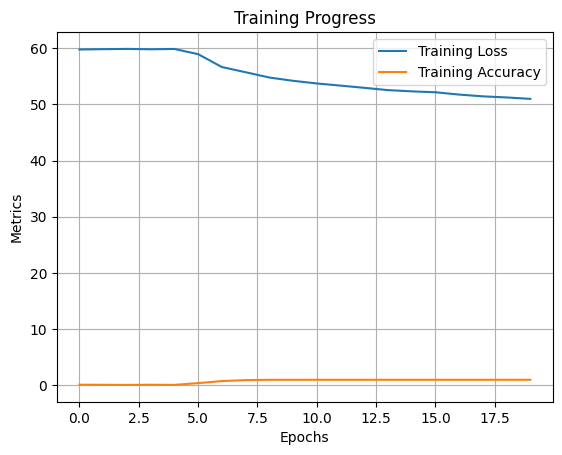

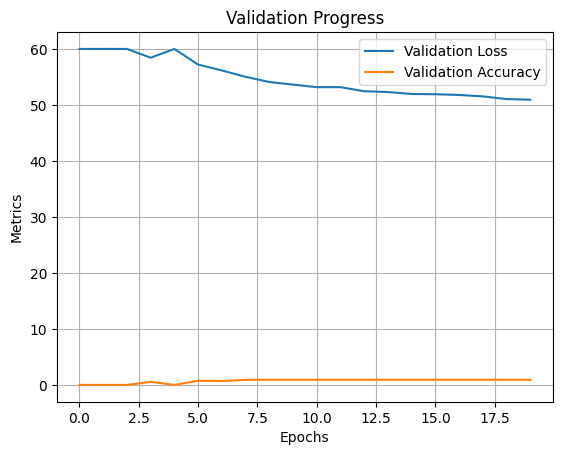

In [32]:
# Plotting training loss and accuracy
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Training Progress')
plt.legend()
plt.grid(True)
plt.show()

# Plotting validation loss and accuracy
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Validation Progress')
plt.legend()
plt.grid(True)
plt.show()


### Get 4 metrics

In [33]:
# Load the saved weights into the model
#model.load_weights("model_weights.h5")

In [34]:
valid_df.head()

,index,image_id,sat_image_path,mask_path
239,2848,504527,./train/504527_sat.jpg,./train/504527_mask.png
1119,4084,686523,./train/686523_sat.jpg,./train/686523_mask.png
2215,3230,56468,./train/56468_sat.jpg,./train/56468_mask.png
2500,2455,450548,./train/450548_sat.jpg,./train/450548_mask.png
5783,4593,758779,./train/758779_sat.jpg,./train/758779_mask.png


In [45]:
import numpy as np

I_stats = [] # empty list of sat maps
Y_stats = [] # empty list of true labels
P_stats = [] # empty list of predictions
P_base_stats = [] # empty list of all zeros arrays which should help us find out model's baseline

I = [] # empty list of sat maps
Y = [] # empty list of true labels
P = [] # empty list of predictions


data_size = [len(valid_df),256,256]

reduced_data = valid_df[0:data_size[0]].reset_index(drop=True)

# Read into the program each image:
for img, mask in zip(reduced_data.sat_image_path, reduced_data.mask_path):
    img = cv2.cvtColor(cv2.imread(img),cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(data_size[1],data_size[2]))
    img = img/255.

    img = img.reshape((-1, 256, 256, 3))

    mask = cv2.cvtColor(cv2.imread(mask),cv2.COLOR_BGR2RGB)
    mask = cv2.resize(mask,(data_size[1],data_size[2]))
    mask = mask/255.


    pred = model.predict(img, verbose = 0)  # Make predictions for the batch

    #print(mask.shape)
    #print(pred.shape)

    temp_mask = mask[:,:,0].reshape((-1, 256, 256, 1))

    I.extend(img)
    Y.extend(temp_mask)# this is because its a binary mask and img is present in channel 0
    P.extend(pred)

    mask = mask[:,:,0].reshape((256 * 256))
    pred_baseline = np.zeros(mask.shape)
    pred = pred.reshape((256 * 256))

    #acc = np.sum(mask == pred) / np.size(mask)
    #pre = np.sum(mask * pred) / np.sum(pred)
    #rec = np.sum(mask * pred) / np.sum(mask)
    #f1 = 2 * pre * rec / (pre + rec)


    I_stats.extend(img)
    Y_stats.extend(mask)# this is because its a binary mask and img is present in channel 0
    P_base_stats.extend(pred_baseline)
    P_stats.extend(pred)
    #break;

#print("Accuracy:", acc)
#print("Precision:", pre)
#print("Recall:", rec)
#print("F1-score:", f1)

In [36]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

Y_stats = np.array(Y_stats)
P_stats = np.array(P_stats)
P_base_stats = np.array(P_base_stats)

print("Y_stats shape:", Y_stats.shape)
print("P_stats shape:", P_stats.shape)

# Convert data types to float32
Y_stats = Y_stats.astype(np.int64)
P_stats = P_stats.astype(np.int64)

print("Y_stats data type:", Y_stats.dtype)
print("P_stats data type:", P_stats.dtype)

# Calculate evaluation metrics
# For multi-class segmentation
accuracy = accuracy_score(Y_stats.flatten(), np.round(P_stats).flatten())
precision = precision_score(Y_stats.flatten(), np.round(P_stats).flatten(), average='weighted')
recall = recall_score(Y_stats.flatten(), np.round(P_stats).flatten(), average='weighted')
f1 = f1_score(Y_stats.flatten(), np.round(P_stats).flatten(), average='weighted')

# Calculate Base evaluation metrics
# For multi-class segmentation
base_accuracy = accuracy_score(Y_stats.flatten(), np.round(P_base_stats).flatten())
base_precision = precision_score(Y_stats.flatten(), np.round(P_base_stats).flatten(), average='weighted')
base_recall = recall_score(Y_stats.flatten(), np.round(P_base_stats).flatten(), average='weighted')
base_f1 = f1_score(Y_stats.flatten(), np.round(P_base_stats).flatten(), average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

print("Base Accuracy:", base_accuracy)
print("Base Precision:", base_precision)
print("Base Recall:", base_recall)
print("Base F1-score:", base_f1)

print("Improvement Accuracy:", accuracy - base_accuracy)
print("Improvement Precision:", precision - base_precision)
print("Improvement Recall:", recall - base_recall)
print("Improvement F1-score:", f1 - base_f1)

#print(Y_stats)
#print(P_stats)

Y_stats shape: (81592320,)
P_stats shape: (81592320,)
Y_stats data type: int64
P_stats data type: int64


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.9614323872638993
Precision: 0.9243522352799606
Recall: 0.9614323872638993
F1-score: 0.9425277580629591
Base Accuracy: 0.9614323872638993
Base Precision: 0.9243522352799606
Base Recall: 0.9614323872638993
Base F1-score: 0.9425277580629591
Improvement Accuracy: 0.0
Improvement Precision: 0.0
Improvement Recall: 0.0
Improvement F1-score: 0.0


Image shape: 1245, Mask shape: 1245


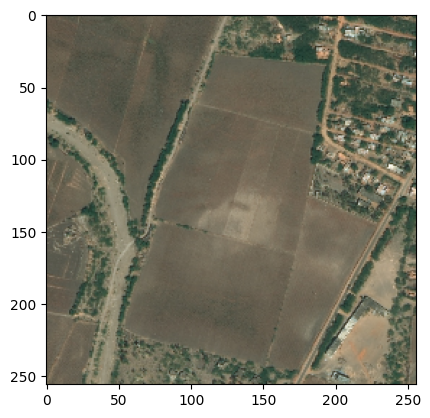

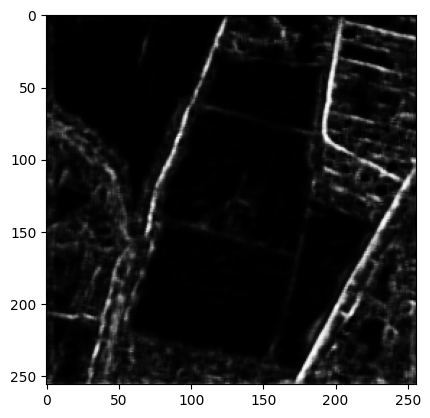

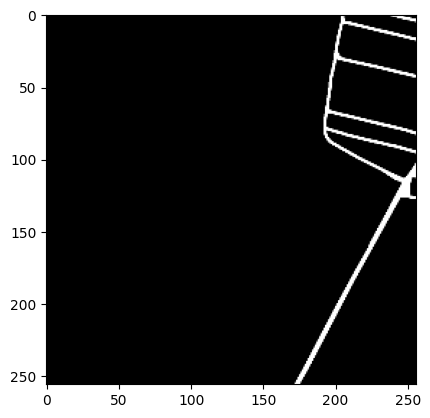

Image shape: 1245, Mask shape: 1245


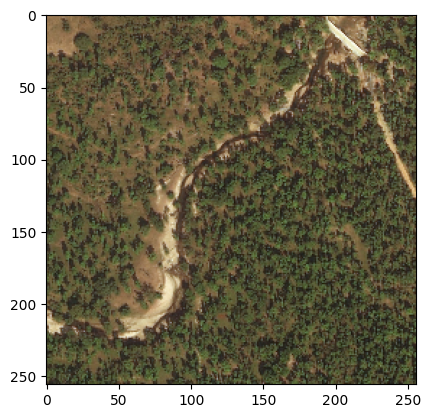

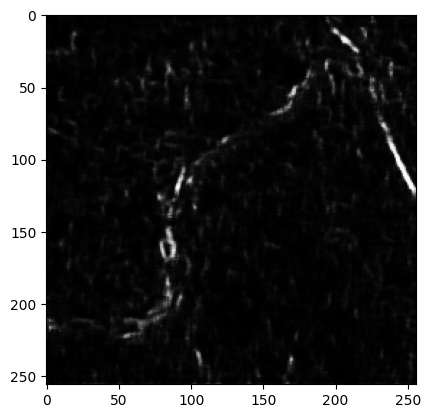

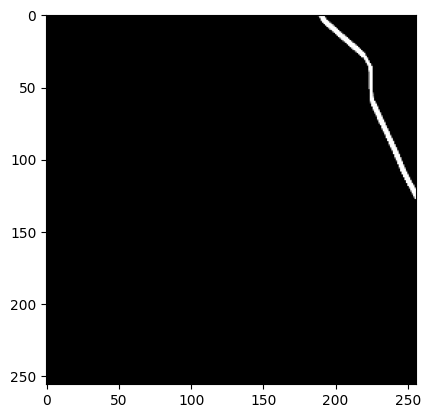

Image shape: 1245, Mask shape: 1245


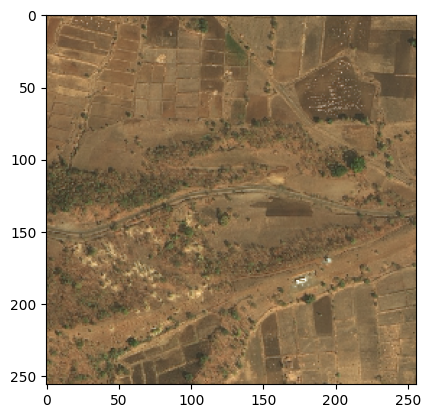

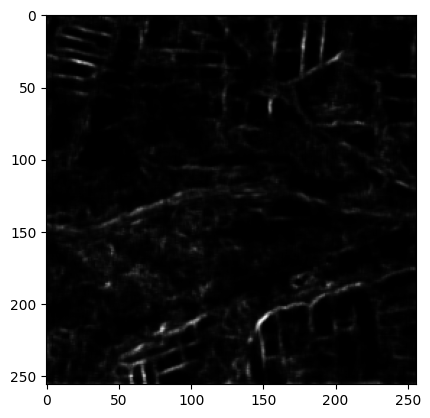

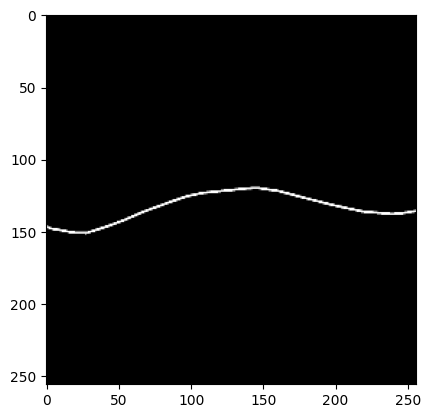

Image shape: 1245, Mask shape: 1245


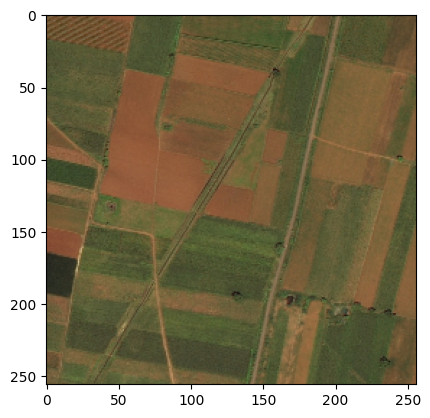

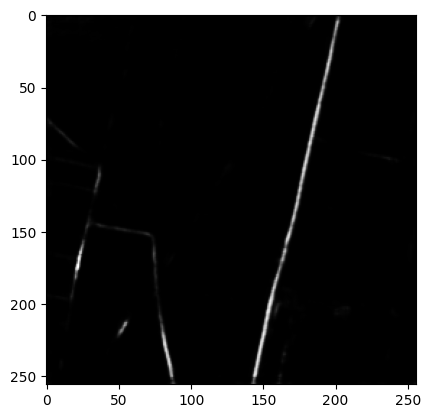

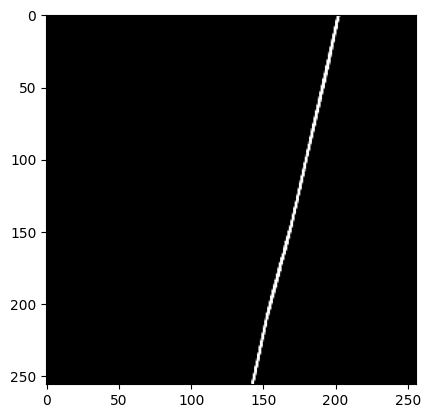

Image shape: 1245, Mask shape: 1245


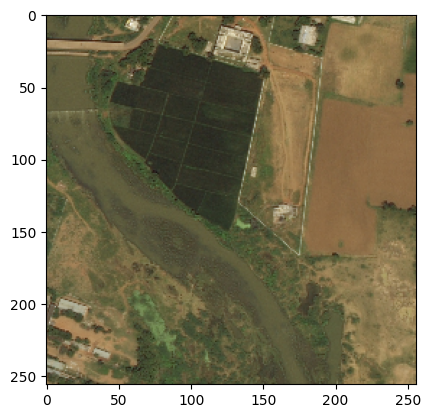

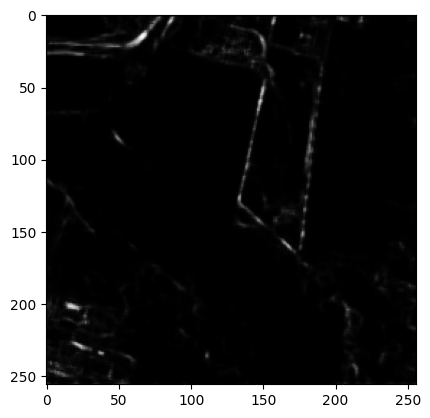

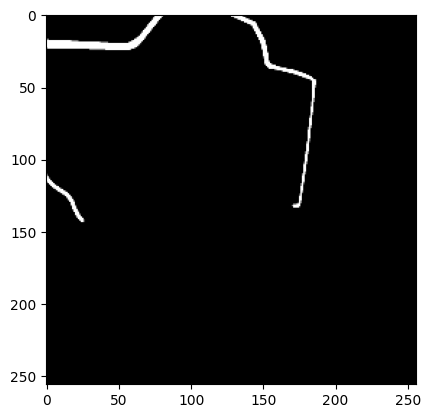

In [37]:
for i in range(5):
  random_idx = random.randint(0, len(I)-1)
  #image, mask = reduced_data[random_idx].sat_image_path, reduced_data[random_idx].mask_path # get some random sample
  print(f"Image shape: {len(I)}, Mask shape: {len(P)}")
  import matplotlib.pyplot as plt
  plt.imshow(I[random_idx])
  plt.show()

  # Convert multi-channel mask to single-channel mask just for the sake of showing it.
  mask_single_channel = P[random_idx]
  plt.imshow(mask_single_channel, cmap='gray')
  plt.show()

  # Convert multi-channel mask to single-channel mask just for the sake of showing it.
  mask_single_channel = Y[random_idx]
  plt.imshow(mask_single_channel, cmap='gray')
  plt.show()

In [120]:
Y_temp = np.array(Y)
P_temp = np.array(P)
I_temp = np.array(I)
difference =  np.array(np.round(P_temp) - np.round(Y_temp))
#image, mask = reduced_data[random_idx].sat_image_path, reduced_data[random_idx].mask_path # get some random sample
print(f"Image shape: {len(I_temp)}, Mask shape: {len(P_temp)}")
import matplotlib.pyplot as plt
#plt.imshow(difference, cmap='gray')
#plt.show()

# Convert multi-channel mask to single-channel mask just for the sake of showing it.
#plt.imshow(P_temp, cmap='gray')
#plt.show()

# Convert multi-channel mask to single-channel mask just for the sake of showing it.
#plt.imshow(Y_temp, cmap='gray')
#plt.show()

print(len(Y_temp.flatten()))
print(len(Y_temp.flatten()) - Y_temp.sum())
print((len(Y_temp.flatten()) - Y_temp.sum())/len(Y_temp.flatten()))
# baseline is 59174/65536 = 90%

#truevalues = Y_temp.flatten()
#predvalues = P_temp.flatten().round()
#predvalues = np.full_like(truevalues, 0)

#print(len(truevalues))

#x = truevalues[:253]
#print(len(predvalues))
# accuracyscore = accuracy_score(x, x)
#print(accuracyscore)

#print(truevalues[252:255])


Image shape: 1245, Mask shape: 1245
81592320
78093483.7137254
0.9571180683883656


## Convert to HTML this notebook

In [39]:
#%%shell
#jupyter nbconvert --to html /content/True_Final_Project_Task_2.ipynb